## Implementation of Epsilon-Greedy

In [54]:
import numpy as np
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Helper functions for all algorithms 
def nsw(mu_matrix, policy):
    """
    Computes the Net Social Welfare (NSW) given a utility matrix and a policy.
    """

    expected_utilities = np.dot(mu_matrix, policy)
    #nash social welfare is product of expected utilities
    nsw = np.prod(expected_utilities)
    return nsw

def get_objective_func(mu_matrix):

    def objective_func(p):
        p = np.asarray(p)
        expected_utilities = np.dot(mu_matrix, p)
        nsw = np.prod(expected_utilities)
        return -1 * nsw
    
    return objective_func


def get_optimal_policy(mu_matrix):
    """
    Get the policy from the objective function.
    """

    # Objective function
    objective = get_objective_func(mu_matrix)

    # Constraint 
    def constraint(p):
        return 1 - sum(p)

    # Bounds and constraints
    bounds = [(0, 1)] * mu_matrix.shape[1]
    constraints = [{'type': 'eq', 'fun': constraint}]
    initial_guess = np.ones(mu_matrix.shape[1]) / mu_matrix.shape[1]

    result = minimize(objective, initial_guess, bounds=bounds, constraints=constraints, method='SLSQP')

    return result.x

In [34]:
#This function performs the Epsilon-Greedy algorithm with N agents and K arms. Each arm is gaussian with stdev = 0.1
def epsilon_greedy(mu_matrix, horizon, num_simulations):

    optimal_policy = get_optimal_policy(mu_matrix)
    optimal_nsw = nsw(mu_matrix, optimal_policy)
    regrets = []
    policies = []   

    num_agents = mu_matrix.shape[0]
    num_arms = mu_matrix.shape[1]

    for i in tqdm(range(num_simulations)):

        policy_history = []

        # Step 0: Initialize variables
        regret = 0
        curr = 0
        mu_hat_matrix = np.zeros(mu_matrix.shape)
        
        #for computing estimators
        mu_hat_totals = np.zeros(mu_matrix.shape)
        mu_hat_counts = np.zeros(mu_matrix.shape)

        for t in range(1, horizon + 1):
            eps_t = min(1, (num_agents ** (2/3)) * (num_arms ** (1/3)) * (t ** (-1/3)) * (np.log(t*num_agents*num_arms) ** (1/3)))

            if np.random.rand() < eps_t:
                #Round Robin Exploration
                for j in range(mu_matrix.shape[0]):
                    sample = np.random.normal(mu_matrix[j][curr], 0.1)
                    mu_hat_totals[j][curr] += sample
                    mu_hat_counts[j][curr] += 1

                #policy for this round is a one hot vector over arms with position curr = 1
                policy = np.zeros(mu_matrix.shape[1])
                policy[curr] = 1

                # Now we update regret based on the policy for this round 
                regret += (optimal_nsw - nsw(mu_matrix, policy)) 

                curr = (curr + 1) % num_arms
            
            else:
                #Update the estimators to find the optimal policy
                mu_hat_matrix = mu_hat_totals / mu_hat_counts

                policy = get_optimal_policy(mu_hat_matrix)
                policy_history.append(policy)

                #sample from an arm k from 0 to num_arms with probs given by the policy
                k = np.random.choice(num_arms, p=policy)

                for j in range(mu_matrix.shape[0]):
                    sample = np.random.normal(mu_matrix[j][k], 0.1)
                    mu_hat_totals[j][k] += sample
                    mu_hat_counts[j][k] += 1
                    
                # Now we update regret based on the policy for this round
                regret += (optimal_nsw - nsw(mu_matrix, policy))

               

        regrets.append(regret)
        policies.append(policy_history) 
            
    return regrets, policies

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:34<00:00,  9.48s/it]


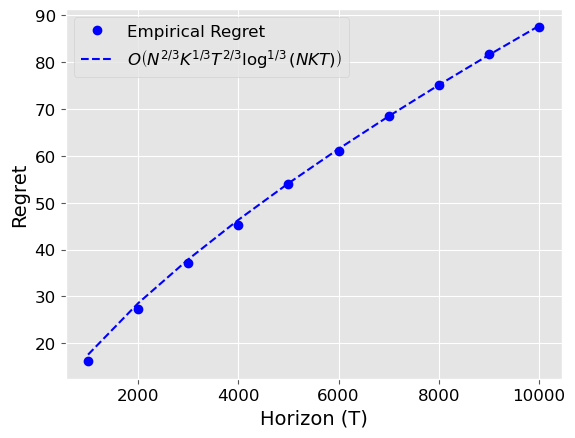

In [39]:
#try 3x3 test array
mu_matrix = np.array([[0.3, 0.5, 0.7],
                        [0.7, 0.3, 0.5],
                        [0.5, 0.7, 0.3]])

#try explore then commit for different horizons from 1000 to 10000
horizons = np.linspace(10**3, 10**4, 10)    

with plt.style.context('ggplot'):
    #for each horizon, run the explore then commit algorithm and plot the regrets, with stderror bars across the simulations
    for horizon in horizons:
        regrets, policies = epsilon_greedy(mu_matrix, horizon=int(horizon), num_simulations=10)
        mean_regret = np.mean(regrets)
        std_error = np.std(regrets) / np.sqrt(len(regrets))

        # Plotting the results
        plt.errorbar(horizon, mean_regret, yerr=std_error, marker='o', color='b')

    plt.plot([], [], 'ob', label='Empirical Regret')

    #plot theoretical regret bound 
    num_agents = mu_matrix.shape[0]
    num_arms = mu_matrix.shape[1]
    C = 0.028 # determined empirically 
    theoretical_regret = C * num_agents**(2/3) * num_arms**(1/3) * (horizons**(2/3)) * (np.log(horizons*num_agents*num_arms)**(1/3))
    plt.plot(horizons, theoretical_regret, 'b--', label=r'$O\left(N^{2/3} K^{1/3} T^{2/3} \log^{1/3}(NKT)\right)$')

    plt.xlabel('Horizon (T)', fontsize=14, color='black')
    plt.ylabel('Regret', fontsize=14, color='black')
    plt.tick_params(axis='both', labelsize=12, labelcolor='black')
    plt.legend(fontsize=12, loc='upper left')
    plt.show()

100%|██████████| 3/3 [00:26<00:00,  8.89s/it]


Optimal p1: 0.3333333333333333
Optimal p2: 0.3333333333333333
Optimal p3: 0.3333333333333333


/var/folders/mf/2cn54l592v59ftz5czx_4x_m0000gn/T/ipykernel_4882/2288593113.py:84: UserWarning: Adding colorbar to a different Figure <Figure size 640x480 with 2 Axes> than <Figure size 640x480 with 1 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(surf, format='%.3f', shrink=0.8, aspect=10, pad=0.1)


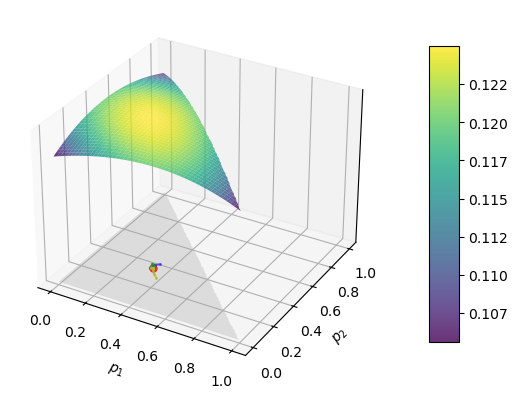

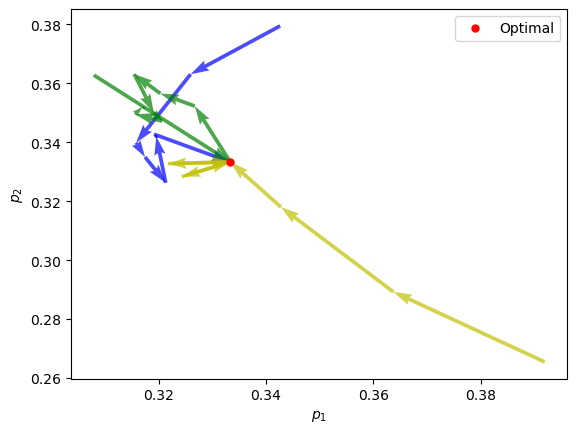

In [79]:
mu_matrix = np.array([[0.3, 0.5, 0.7,],
                       [0.7, 0.3, 0.5],
                       [0.5, 0.7, 0.3]])

regrets, policies = epsilon_greedy(mu_matrix, horizon=10**4, num_simulations=3)

objective = get_objective_func(mu_matrix)
# Optimization
optimal_p1, optimal_p2, optimal_p3 = get_optimal_policy(mu_matrix)

print(f"Optimal p1: {optimal_p1}")
print(f"Optimal p2: {optimal_p2}")
print(f"Optimal p3: {optimal_p3}")

# Grid setup
p1_vals = np.linspace(0, 1, 200)
p2_vals = np.linspace(0, 1, 200)
P1, P2 = np.meshgrid(p1_vals, p2_vals)
P3 = 1 - P1 - P2

# Create mask for valid (feasible) region
mask = P3 >= 0

# Compute Z only where the mask is valid
Z = np.full(P1.shape, np.nan)
for i in range(P1.shape[0]):
    for j in range(P1.shape[1]):
        if mask[i, j]:
            Z[i, j] = -1 * objective([P1[i, j], P2[i, j], P3[i, j]])

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Objective surface
surf = ax.plot_surface(P1, P2, Z, cmap='viridis', edgecolor='none', alpha=0.8)

# Shade feasible region in xy-plane (z=0)
Z_plane = np.zeros_like(P1)
Z_plane[~mask] = np.nan  # Hide infeasible part
ax.plot_surface(P1, P2, Z_plane, color='lightgray', alpha=0.3)

fig2, ax2 = plt.subplots()

# Add optimal point
ax2.plot([optimal_p1], [optimal_p2], 'ro', label='Optimal', markersize=5)
# Plot optimal point
ax.plot([optimal_p1], [optimal_p2], [0], 'ro', markersize=5)

num_simulations = len(policies)
horizon = len(policies[0])

num_simulations = len(policies)
colors = ('b', 'g', 'y')  # Define a color map

for idx, sim_policy in enumerate(policies):
    color = colors[idx]  # Get a unique color for this simulation

    sample_indices = np.linspace(0, len(sim_policy) - 1, 10, dtype=int)

    p1s = np.asarray([sim_policy[i][0] for i in sample_indices])
    p2s = np.asarray([sim_policy[i][1] for i in sample_indices])
    
    # Plot on ax (e.g. 3D or 2D line)
    ax.plot(p1s, p2s, marker='o', linestyle='-', alpha=0.7, markersize=1, color=color)

    # Compute vectors
    u = p1s[1:] - p1s[:-1]
    v = p2s[1:] - p2s[:-1]

    # Plot on ax2 (2D with arrows)
    ax2.quiver(p1s[:-1], p2s[:-1], u, v, angles='xy', scale_units='xy', scale=1,
               alpha=0.7, color=color)

# Labels and display
ax2.set_xlabel(r'$p_1$')
ax2.set_ylabel(r'$p_2$')
ax2.legend()

ax.set_xlabel(r'$p_1$')
ax.set_ylabel(r'$p_2$')
ax.set_zticks([])
ax.set_zticklabels([])
cbar = plt.colorbar(surf, format='%.3f', shrink=0.8, aspect=10, pad=0.1)
cbar.ax.tick_params(labelsize=10)


plt.show()